# Analisi dei dati raccolti

## Setup

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from types import FunctionType

In [25]:
def plotter(dataframes: list, index: str, names: list, space: int) -> None:
    xvalues_int = list()
    xvalues_str = list()
    for name in names:
        xvalues_str.extend(["", name, ""])

    plt.gcf().set_size_inches(10, 6)
    plt.title("Cifratura" if "E" in index else "Decifratura")
    plt.ylabel("Tempo di esecuzione")
    
    start = 1
    ymax = 0
    for dataframe in dataframes:
        series = dataframe[index]
        ymax = max(ymax, max(series))
        x = [start, start+1, start+2]
        xvalues_int.extend(x)
        plt.bar(x, [series.min(), series.mean(), series.max()])
        start += 5
    
    plt.xticks(xvalues_int, xvalues_str, rotation=90)
    plt.yticks([i for i in range(0, ymax+space, space)])
    plt.grid(axis="y")
    
    plt.show()

In [26]:
PATH = "../ascon128v12/data/{}.csv"

IMPLEMENTATIONS = [
    "armv6m", "armv6m_lowsize", "bi32", "bi32_armv6m", "bi32_lowreg", "bi32_lowsize", "opt32", "opt32_lowsize", "ref"
]

armv6m = pd.read_csv(open(PATH.format("armv6m"), "r"), delimiter=";")
armv6m_lowsize = pd.read_csv(open(PATH.format("armv6m_lowsize"), "r"), delimiter=";")
bi32 = pd.read_csv(open(PATH.format("bi32"), "r"), delimiter=";")
bi32_armv6m = pd.read_csv(open(PATH.format("bi32_armv6m"), "r"), delimiter=";")
bi32_lowreg = pd.read_csv(open(PATH.format("bi32_lowreg"), "r"), delimiter=";")
bi32_lowsize = pd.read_csv(open(PATH.format("bi32_lowsize"), "r"), delimiter=";")
opt32 = pd.read_csv(open(PATH.format("opt32"), "r"), delimiter=";")
opt32_lowsize = pd.read_csv(open(PATH.format("opt32_lowsize"), "r"), delimiter=";")
ref = pd.read_csv(open(PATH.format("ref"), "r"), delimiter=";")

DATAFRAMES = [
    armv6m, armv6m_lowsize, bi32, bi32_armv6m, bi32_lowreg, bi32_lowsize, opt32, opt32_lowsize, ref
]

INDEX = armv6m.columns

## Grafici

Ogni grafico presente in questo notebook è suddiviso in nove parti, ognuna delle quali contiene una rappresentazione dei dati raccolti durante il testing in fase di cifratura o decifratura di una data implementazione

Le implementazioni, che vanno a indicizzare l'asse delle X, vengono rappresentate da tre barre:
* la barra di sinistra rappresenta il valore **minimo**
* la barra centrale rappresenta il valore **medio**
* la barra di destra rappresenta il valore **massimo**

I valori sull'asse Y rappresentano il tempo di esecuzione in **microsecondi**

### PT vuoto

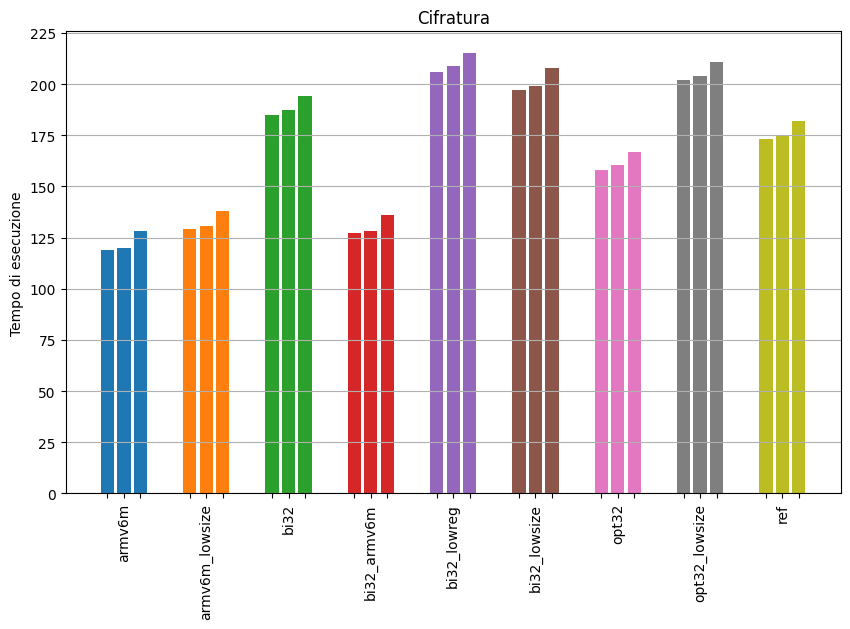

In [27]:
# Cifratura
plotter(DATAFRAMES, "0B-E", IMPLEMENTATIONS, 25)

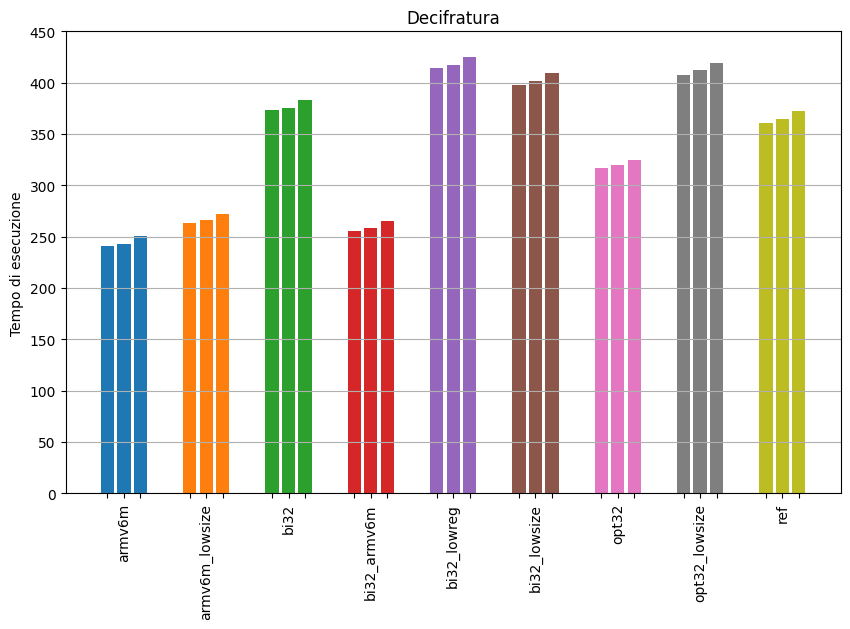

In [28]:
# Decifratura
plotter(DATAFRAMES, "0B-D", IMPLEMENTATIONS, 50)

### PT 1 byte

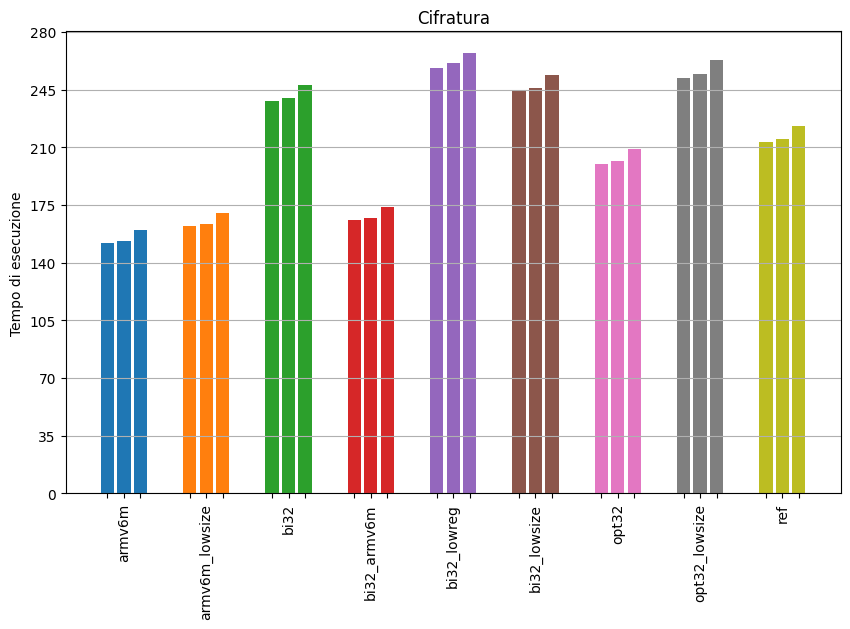

In [29]:
# Cifratura
plotter(DATAFRAMES, "1B-E", IMPLEMENTATIONS, 35)

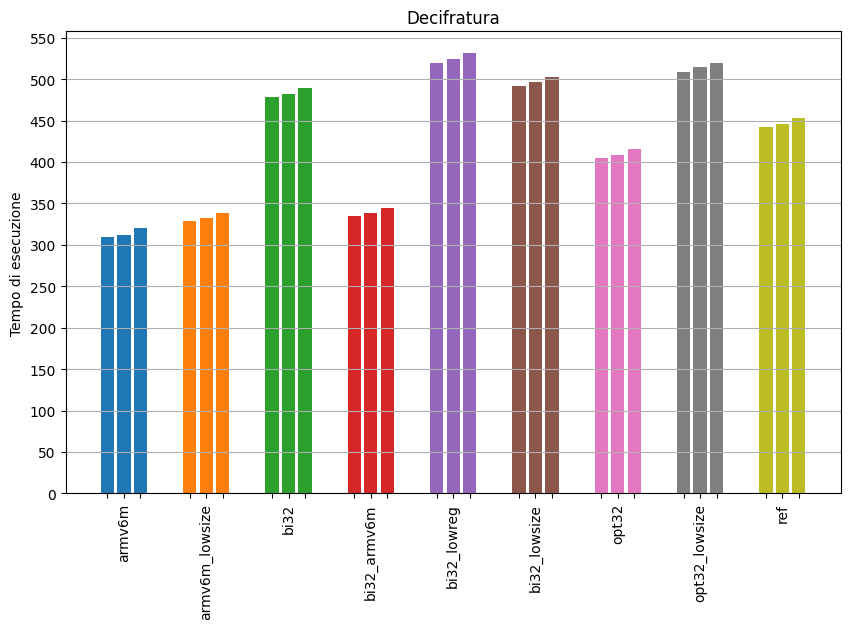

In [30]:
# Decifratura
plotter(DATAFRAMES, "1B-D", IMPLEMENTATIONS, 50)

### PT 8 byte

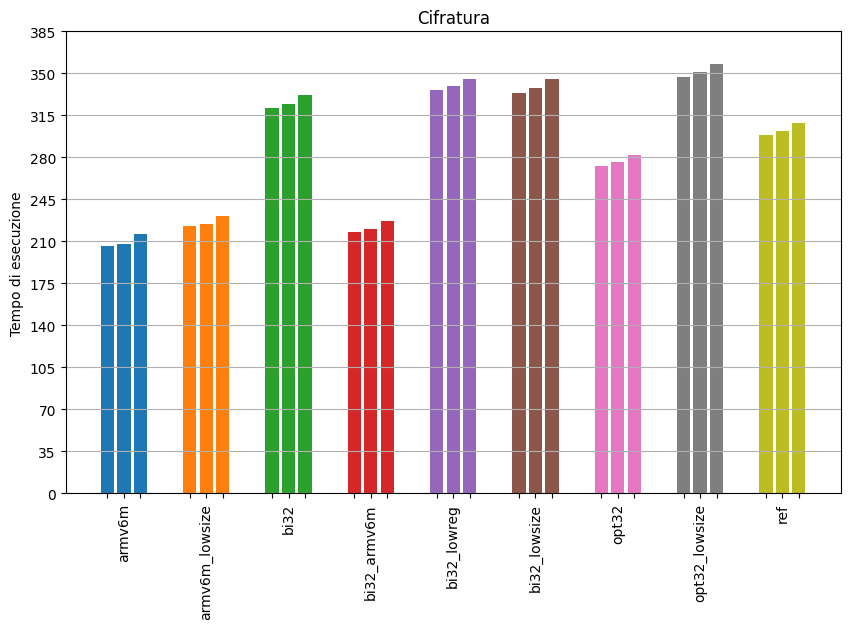

In [31]:
# Cifratura
plotter(DATAFRAMES, "8B-E", IMPLEMENTATIONS, 35)

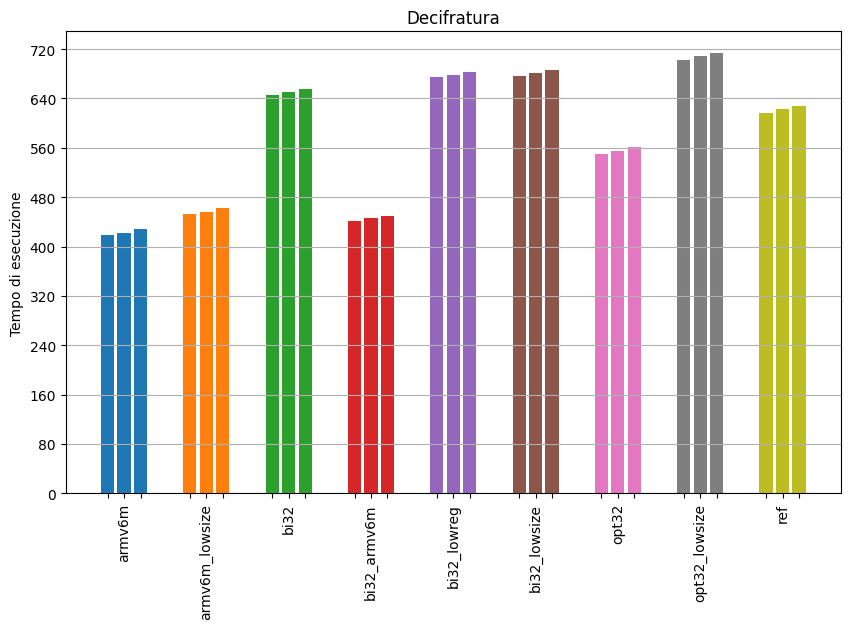

In [32]:
# Decifratura
plotter(DATAFRAMES, "8B-D", IMPLEMENTATIONS, 80)

### PT 16 byte

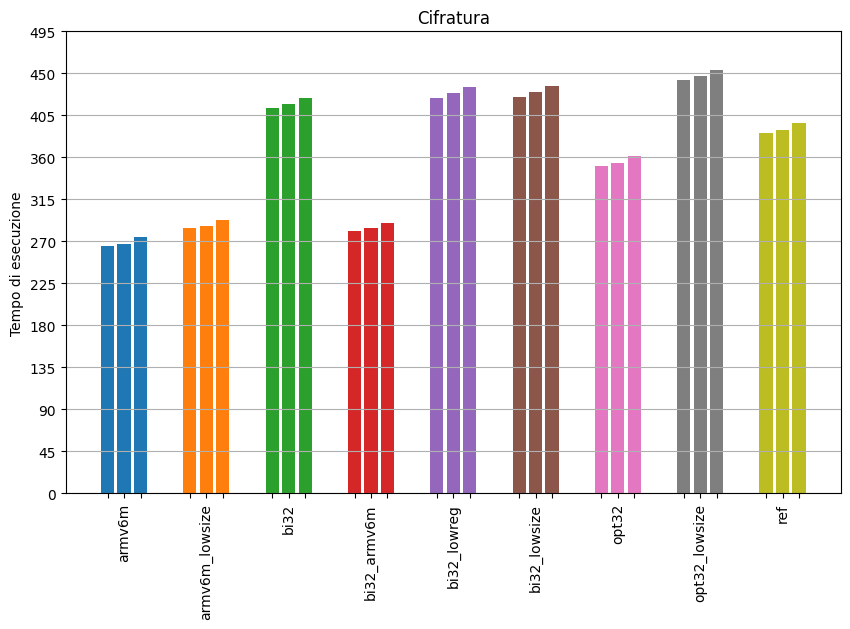

In [33]:
# Cifratura
plotter(DATAFRAMES, "16B-E", IMPLEMENTATIONS, 45)

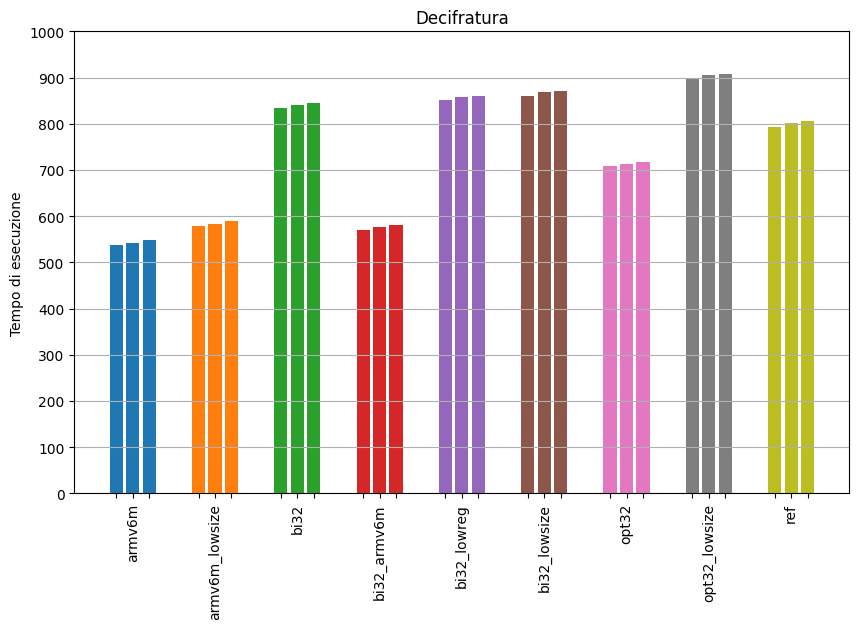

In [34]:
# Decifratura
plotter(DATAFRAMES, "16B-D", IMPLEMENTATIONS, 100)

### PT 24 byte

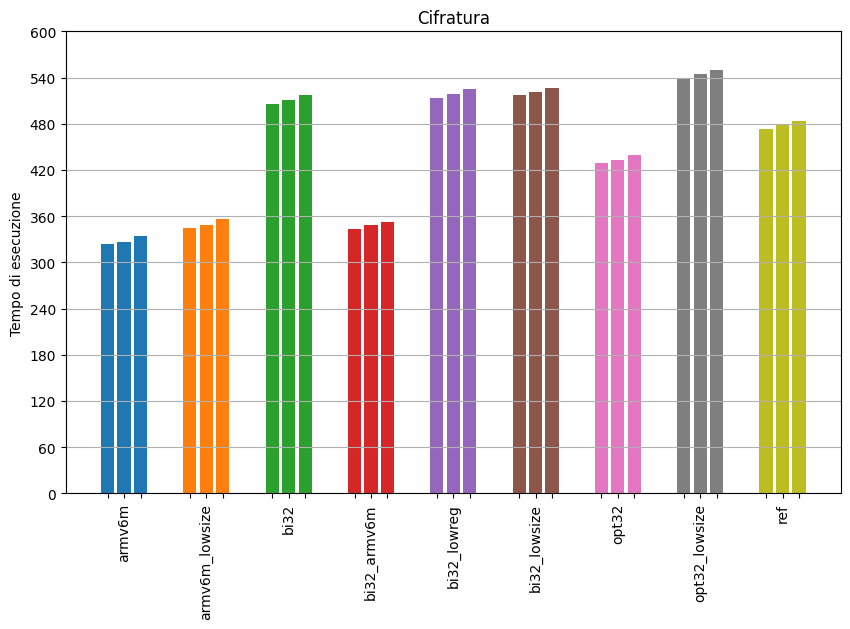

In [35]:
# Cifratura
plotter(DATAFRAMES, "24B-E", IMPLEMENTATIONS, 60)

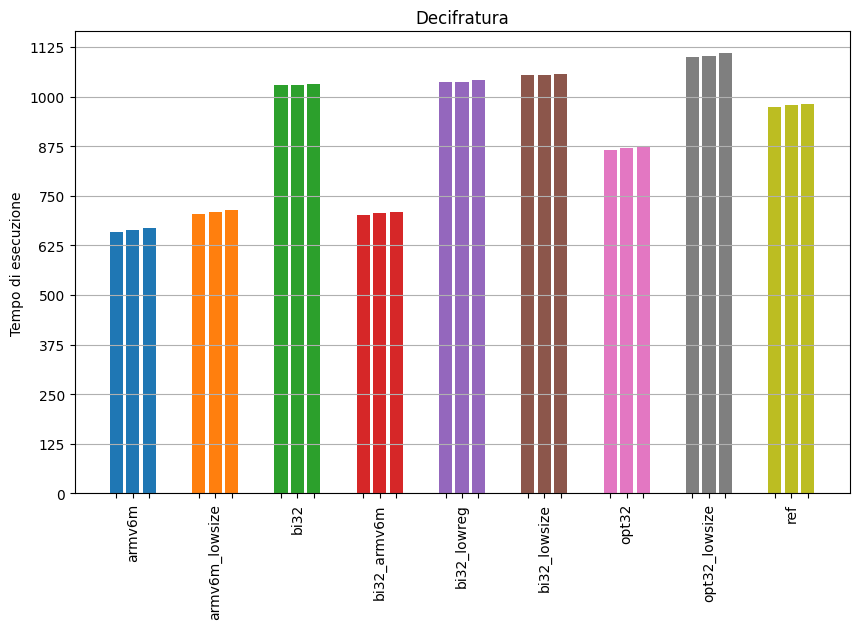

In [36]:
# Decifratura
plotter(DATAFRAMES, "24B-D", IMPLEMENTATIONS, 125)

### PT 32 byte

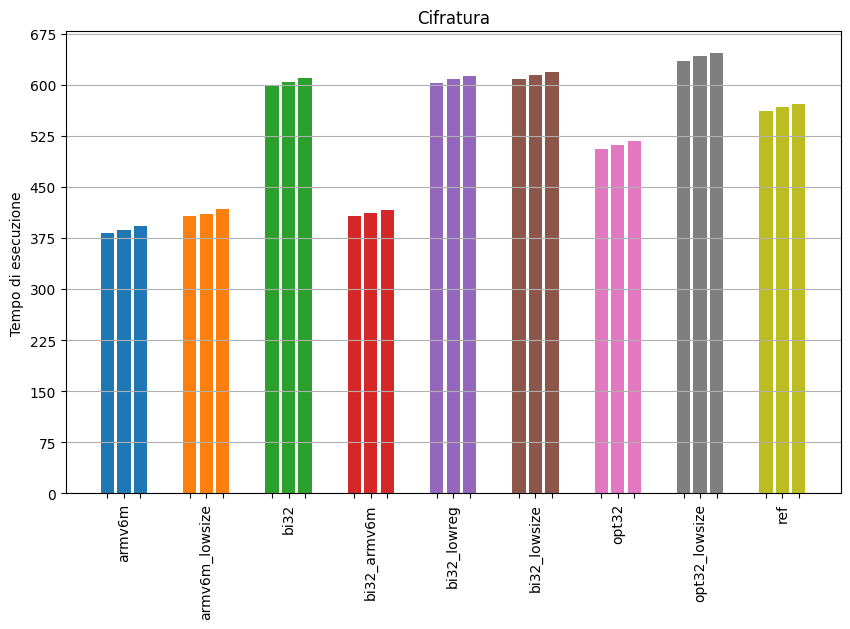

In [37]:
# Cifratura
plotter(DATAFRAMES, "32B-E", IMPLEMENTATIONS, 75)

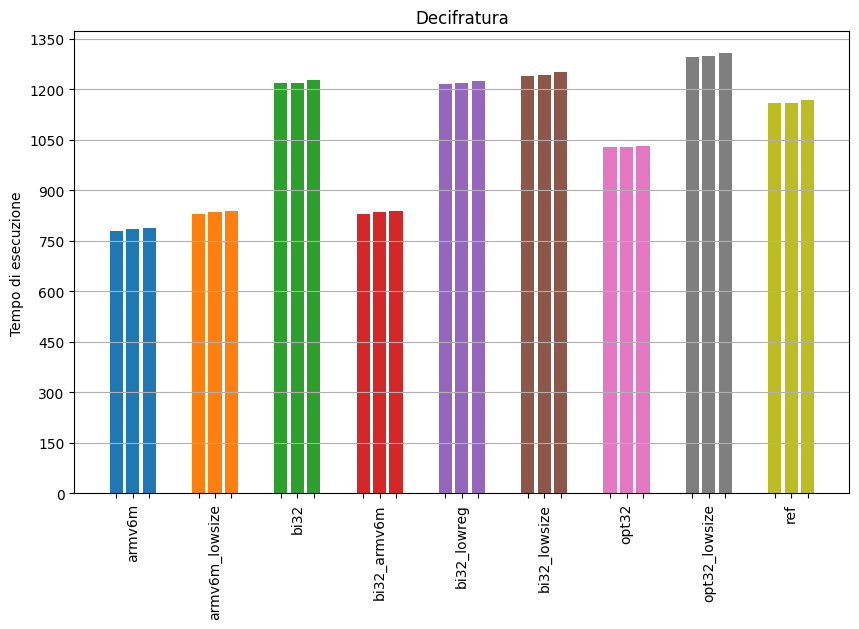

In [38]:
# Decifratura
plotter(DATAFRAMES, "32B-D", IMPLEMENTATIONS, 150)

## Conclusioni

### Setup

In [39]:
def checker(dataframes: list, columns: list, index: int, check: FunctionType) -> None:
    for column in columns:
        test_series = dataframes[index][column]
        for i in range(len(dataframes)):
            if i == index:
                continue
            series = dataframes[i][column]
            assert check(test_series.min(), series.min())
            assert check(test_series.mean(), series.mean())
            assert check(test_series.max(), series.max())

    print("Nessuna AssertionError è stata sollevata")

In [40]:
def template(best: pd.DataFrame, worst: pd.DataFrame, columns: list, calculate: FunctionType) -> None:
    results = [[], [], []]
    for column in columns:
        best_series = best[column]
        worst_series = worst[column]
        results[0].append(calculate(best_series.min(), worst_series.min()))
        results[1].append(calculate(best_series.mean(), worst_series.mean()))
        results[2].append(calculate(best_series.max(), worst_series.max()))
    
    results = [
        [min(results[0]), max(results[0])],
        [min(results[1]), max(results[1])],
        [min(results[2]), max(results[2])]
    ]

    print(f"Rispetto alla misurazione minima: da {results[0][0]} a {results[0][1]}")
    print(f"Rispetto alla misurazione media: da {results[1][0]} a {results[1][1]}")
    print(f"Rispetto alla misurazione massima: da {results[2][0]} a {results[2][1]}")

In [41]:
def times(best: pd.DataFrame, worst: pd.DataFrame, columns: list) -> None:
    def calculate(best: int, worst: int) -> float:
        return np.around( worst/best, 2 )
    template(best, worst, columns, calculate)
    
    
def percentage_increase(best: pd.DataFrame, worst: pd.DataFrame, columns: list) -> None:
    def calculate(best: int, worst: int) -> float:
        return np.around( ((worst * 100) / best) - 100, 2 )
    template(best, worst, columns, calculate)

### Migliori implementazioni

L'implementazione `armv6m` è quella che ha ottenuto i tempi di esecuzione migliori in ogni possibile grandezza di PT considerata

A seguire abbiamo le implementazioni `armv6m_lowsize` e `bi32_armv6m` che, come quella migliore, sono ottimizzate per architetture ARMv6-M

Notiamo come queste ultime due ottimizzazioni sono più lente della versione `armv6m` base, ma più veloci della `opt32`, che è ottimizzata ma per architetture $32$ bit generiche

In [42]:
# Armv6m migliore implementazione
for i in range(0,len(INDEX),2):
    try:
        checker(DATAFRAMES, INDEX[i:i+2], 0, lambda x,y : x < y)
    except AssertionError:
        print(f"Armv6m non domina per {INDEX[i]} e {INDEX[i+1]}")
    print()

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata



### Peggiori implementazioni

Considerando PT di grandezza $0$ e $1$ byte, l'implementazione peggiore è la `bi32_lowreg`

Quasi a pari merito troviamo poi le implementazioni `bi32_lowsize` e `opt32_lowsize`, che, come quella peggiore, sono ottimizzate per architetture $32$ bit generiche

Quest'ultima implementazione invece la troviamo come peggiore nei PT con grandezza $8$, $16$, $24$ e $32$ byte, seguita dalle restanti due e dalla `bi32`, anch'essa ottimizzata per architetture $32$ bit generiche; volendo quantizzare il peggioramento percentuale rispetto alla implementazione migliore, la `opt32_lowsize` risulta essere più lenta del $62/70$\%

Notiamo subito come le implementazioni peggiori sono quelle che cercano di ottimizzare architetture $32$ bit generiche, facendo peggio anche dell'implementazione di riferimento `ref`, che è priva di ottimizzazioni

In [43]:
# Bi32_lowreg e opt32_lowsize peggiori implementazioni
for i in range(0,len(INDEX),2):
    try:
        checker(DATAFRAMES, INDEX[i:i+2], 4, lambda x,y : x > y)
    except AssertionError:
        print(f"Bi32_lowreg non domina per {INDEX[i]} e {INDEX[i+1]}")
    try:
        checker(DATAFRAMES, INDEX[i:i+2], 7, lambda x,y : x > y)
    except AssertionError:
        print(f"Opt32_lowsize non domina per {INDEX[i]} e {INDEX[i+1]}")
    print()

Nessuna AssertionError è stata sollevata
Opt32_lowsize non domina per 0B-E e 0B-D

Nessuna AssertionError è stata sollevata
Opt32_lowsize non domina per 1B-E e 1B-D

Bi32_lowreg non domina per 8B-E e 8B-D
Nessuna AssertionError è stata sollevata

Bi32_lowreg non domina per 16B-E e 16B-D
Nessuna AssertionError è stata sollevata

Bi32_lowreg non domina per 24B-E e 24B-D
Nessuna AssertionError è stata sollevata

Bi32_lowreg non domina per 32B-E e 32B-D
Nessuna AssertionError è stata sollevata



In [44]:
# Opt32_lowsize quanti punti percentuali è peggio di armv6m, migliore
percentage_increase(armv6m, opt32_lowsize, INDEX)

Rispetto alla misurazione minima: da 64.72 a 69.75
Rispetto alla misurazione media: da 65.09 a 70.07
Rispetto alla misurazione massima: da 62.5 a 66.93


### Dimensione eseguibile

Potevamo aspettarcelo dal nome: le implementazioni `lowsize` sono quelle che hanno una dimensione dell'eseguibile molto piccola, occupando circa il $6/7$\% dello spazio disponibile, mentre le implementazioni `ref` e `opt32` sono quelle più pesanti, occupando circa il $20/21$\% dello spazio disponibile

Considerando l'implementazione migliore, quindi la `armv6m`, essa occupa circa il $8/9$\% dello spazio disponibile, dimostrandosi un'ottima soluzione anche per quanto riguarda lo spazio occupato